# Отток клиентов

## Описание

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постром модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

- Загрузим и подготовим данные, поясния порядок действий.

- Исследуем баланс классов, обучим модель без учёта дисбаланса. Кратко опишим выводы.

- Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдём лучшую. Кратко опишим выводы.

- Проведите финальное тестирование.

Описание данных
- Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). [Скачать датасет](https://code.s3.yandex.net/datasets/Churn.csv "https://code.s3.yandex.net/datasets/Churn.csv")

Признаки
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак
- `Exited` — факт ухода клиента

## Подготовка данных

### Загрузка библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import os.path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_score, recall_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

plt.style.use('dark_background')

У нас есть две ссылки на датасет и эти датасеты не идентичны. Загрузим оба и сравним

Так как на kaggle он в архиве, то если он не скачан, альтернативным способом подгружаем дабликат с гитхаба, там он идентичен

In [2]:
# датаест с сервера яндекс
try:
    path = os.path.join('/datasets/Churn.csv')
    data = pd.read_csv(path)
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

# датасет с kaggle
try:
    path_k = os.path.join('/datasets/Churn_Modelling.csv')
    data_k = pd.read_csv(path_k)
except:
    data_k = pd.read_csv('https://raw.githubusercontent.com/sharmaroshan/Churn-Modelling-Dataset/master/Churn_Modelling.csv')


### Первичный осмотр данных

In [3]:
# Функция для вывода первичной информации по датасету
def first_view(data):
    title_lenght = 79
    title_one = 'Обзор данных первых и последних пяти строк'
    print('~' * int((title_lenght - len(title_one)) / 2), title_one, '~' * (title_lenght - len(title_one) - int((title_lenght - len(title_one)) / 2)))
    display(data.head(5))
    display(data.tail(5))
    print()
    title_two = 'Основная описательная статистика'
    print('~' * int((title_lenght - len(title_two)) / 2), title_two, '~' * (title_lenght - len(title_two) - int((title_lenght - len(title_two)) / 2)))
    display(data.describe())
    print()
    title_three = 'Тип данных' 
    print('~' * int((title_lenght - len(title_three)) / 2), title_three, '~' * (title_lenght - len(title_three) - int((title_lenght - len(title_three)) / 2)))
    data.info()
    print()
    title_four = 'Подсчёт пропусков'
    print('~' * int((title_lenght - len(title_four)) / 2), title_four, '~' * (title_lenght - len(title_four) - int((title_lenght - len(title_four)) / 2)))
    all_nulls = 0
    for col in data.columns:
       if data[col].isna().sum() > 0:
            all_nulls += 1
            print(f"{data[col].isna().sum()} пропусков в колонке {col}. Это {round(data[col].isna().mean() * 100, 2)}%")
    if all_nulls == 0:
        print('В датафрейме пропуски отсутствуют')
    print()
    title_five = 'Явные дубликаты'
    print('~' * int((title_lenght - len(title_five)) / 2), title_five, '~' * (title_lenght - len(title_five) - int((title_lenght - len(title_five)) / 2)))
    if data.duplicated().sum() > 0:
        print('Количество явных дубликатов - ', data.duplicated().sum())
    else:
        print('Явные дубликаты в датасете отсутствуют')

In [4]:
first_view(data)

~~~~~~~~~~~~~~~~~~ Обзор данных первых и последних пяти строк ~~~~~~~~~~~~~~~~~~~


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.00,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.00,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.00,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.00,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.00,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0



~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

~~~~~~~~~~

In [5]:
first_view(data_k)

~~~~~~~~~~~~~~~~~~ Обзор данных первых и последних пяти строк ~~~~~~~~~~~~~~~~~~~


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0



~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

~~~~~~~~~~

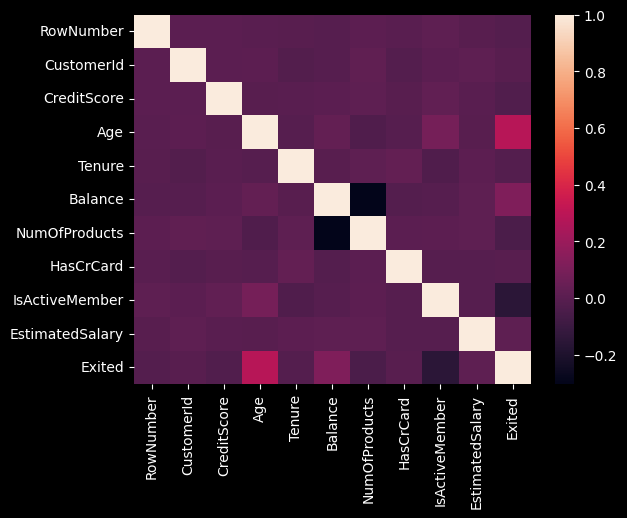

In [6]:
sns.heatmap(data.select_dtypes(include=[float, int]).corr());

In [7]:
print('Классы столбца surname', data['Surname'].unique())
print('Классы столбца geography', data['Geography'].unique())
print('Классы столбца gender', data['Gender'].unique())

Классы столбца surname ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
Классы столбца geography ['France' 'Spain' 'Germany']
Классы столбца gender ['Female' 'Male']


In [8]:
print('Количество уникальных классов в столбце surname =', len(data['Surname'].unique()))

Количество уникальных классов в столбце surname = 2932


Вывод из осмотра данных:

- В датасете с сервера яндекса в столбце `Tenure` присутствует 9% пропусков в то время как в датасете с Kaggle их нет. Предположительно при копировании возникли какие-то ошибки технического или рукотворного характера и данные в копии были утеряны, необходимо об этом сообщить и исправить это. В исходных данных проекта в прекоде описания проекта было сказано что источник данных Kaggle со ссылкой на него, но использовать датасет с Kaggle мы конечно не будем, потому как на сервере указан другой датасет =). 

- Есть три столбца с уникальными значениями каждой строки `RowNumber`, `CustomerId` и `Surname`, которые нам для обучения модели необходимо будет убирать тк они очевидно не влияют на результат и лишь внесут искажения.

- Есть столбцы с типом Object, их необходимо будет закодировать для обучения модели.

- Явных дубликатов не обнаружено.

- Мультиколлинеарность не наблюдается."

### Переименуем столбцы

In [9]:
data = data.rename(columns={
    'RowNumber': 'row_number', 
    'CustomerId': 'customer_id', 
    'Surname': 'surname',
    'CreditScore': 'credit_score',
    'Geography': 'geography',
    'Gender': 'gender',
    'Age': 'age',
    'Tenure': 'tenure',
    'Balance': 'balance',
    'NumOfProducts': 'num_of_products',
    'HasCrCard': 'has_credit_card',
    'IsActiveMember': 'is_active_member',
    'EstimatedSalary': 'estimated_salary',
    'Exited': 'exited'
})

data.columns.tolist()

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_credit_card',
 'is_active_member',
 'estimated_salary',
 'exited']

### Избавимся от пропусков

Можно было бы использовть метод `.fillna()` и заполнить пропуски медианным значением, можно было бы убрать все строки в которых есть пропуски, НО! Так как у нас доступ к исходным данным с датасета Kaggle, просто возьмём данные оттуда, они 100% будут лучше медианных значений =)

In [10]:
data['tenure'] = data_k['Tenure']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_credit_card   10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Отлично, пропусков больше нет =)

## Исследование задачи

### Разбиваем датасет на тренировочную, валидационную и тестовую выборки

In [11]:
x = data.drop('exited', axis=1)
y = data['exited']

x_train_n_valid, x_test, y_train_n_valid, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1337)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_n_valid, y_train_n_valid, test_size=0.25, random_state=1337)

print('Размер тренировочной выборки:')
print(f'признаки {x_train.shape};')
print(f'целевой признак {y_train.shape}')
print(f'это {round((y_train.count() / y.count()) * 100)}% от датасета')
print()
print('Размер валидационной выборки:')
print(f'признаки {x_valid.shape};')
print(f'целевой признак {y_valid.shape}')
print(f'это {round((y_valid.count() / y.count()) * 100)}% от датасета')
print()
print('Размер тестовой выборки:')
print(f'признаки {x_test.shape};')
print(f'целевой признак {y_test.shape}')
print(f'это {round((y_test.count() / y.count()) * 100)}% от датасета')

Размер тренировочной выборки:
признаки (6000, 13);
целевой признак (6000,)
это 60% от датасета

Размер валидационной выборки:
признаки (2000, 13);
целевой признак (2000,)
это 20% от датасета

Размер тестовой выборки:
признаки (2000, 13);
целевой признак (2000,)
это 20% от датасета


### Подготовка признаков

#### Убираем лишние столбцы

Столбцы с уникальными значениями для каждой строки (а именно `row_number` и `customer_id`), стольбцы с фамилиями и столбцы со страной нам не нужны для обучения моделей, избавимся от них

In [12]:
x_train = x_train.drop(['row_number', 'customer_id', 'surname'], axis=1)
x_valid = x_valid.drop(['row_number', 'customer_id', 'surname'], axis=1)
x_test = x_test.drop(['row_number', 'customer_id', 'surname'], axis=1)

#### Кодировка

Столбцы с типом `object` необходимо закодировать. Используем метод `OHE(One-Hot Encoding)`

In [13]:
x_train = pd.get_dummies(x_train, drop_first=True)
x_valid = pd.get_dummies(x_valid, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)

#### Масштабирование

In [14]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(x_train[numeric])

x_train[numeric] = scaler.transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

### Обучим модель RandomForestClassifier

In [15]:
best_rf_model = None
best_rf_f1_result = 0
best_est = 0
for est in range(10, 201, 10):
    model = RandomForestClassifier(random_state=1337, n_estimators=est)
    model.fit(x_train, y_train)
    predict_valid = model.predict(x_valid)  
    f1_result = f1_score(predict_valid, y_valid)
    if f1_result > best_rf_f1_result:
        best_rf_model = model
        best_rf_f1_result = f1_result
        best_est = est

print("F1 лучшей модели RandomForestClassifier:", round(best_rf_f1_result, 4), "при параметре n_estimators =", best_est)

F1 лучшей модели RandomForestClassifier: 0.618 при параметре n_estimators = 140


#### Рассчитаем ROC-AUC и построим график

RandomForestClassifier: ROC-AUC = 0.86


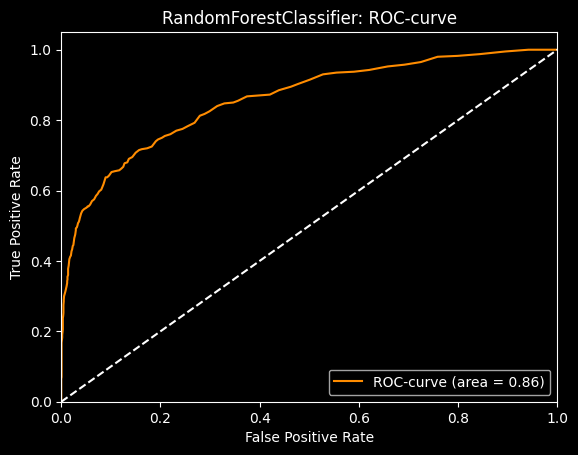

In [16]:
probabilities_valid = best_rf_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
rf_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'RandomForestClassifier: ROC-AUC = {round(rf_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
rf_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(rf_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForestClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

### Обучим модель DecisionTreeClassifier

In [17]:
best_dt_model = None
best_dt_f1_result = 0
best_depth = 0
for depth in range(1, 20):
	model = DecisionTreeClassifier(random_state=1337, max_depth=depth)
	model.fit(x_train, y_train)
	predict_valid = model.predict(x_valid)
	f1_result = f1_score(predict_valid, y_valid)
	if f1_result > best_dt_f1_result:
		best_dt_model = model
		best_dt_f1_result = f1_result
		best_depth = depth
        
print("F1 лучшей модели DecisionTreeClassifier:", round(best_dt_f1_result, 4), "при параметре max_depth =", best_depth)

F1 лучшей модели DecisionTreeClassifier: 0.6046 при параметре max_depth = 7


#### Рассчитаем ROC-AUC и построим график

DecisionTreeClassifier: ROC-AUC = 0.83


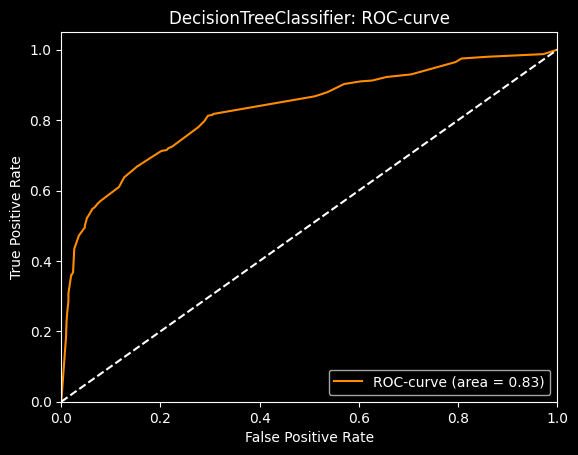

In [18]:
probabilities_valid = best_dt_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
dt_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'DecisionTreeClassifier: ROC-AUC = {round(dt_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
dt_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(dt_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DecisionTreeClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

### Обучим модель логистической регрессии

In [19]:
lr_model = LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000) 
lr_model.fit(x_train, y_train) 
predict_valid = lr_model.predict(x_valid)
lr_f1_result = f1_score(predict_valid, y_valid)

print("F1 модели логистической регрессии:", round(lr_f1_result, 4))

F1 модели логистической регрессии: 0.3258


#### Рассчитаем ROC-AUC и построим график

LogisticRegression: ROC-AUC = 0.77


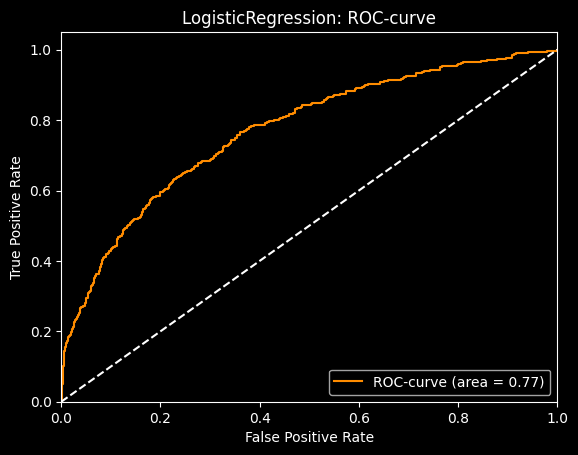

In [20]:
probabilities_valid = lr_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
lr_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'LogisticRegression: ROC-AUC = {round(lr_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
lr_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(lr_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression: ROC-curve')
plt.legend(loc="lower right")
plt.show()

### Сравним модели

In [21]:
model_names = ['RandomForestClassifier', 'DecisionTreeClassifier', 'LogisticRegressionClassifier']
f1_scores = [best_rf_f1_result, best_dt_f1_result, lr_f1_result]
roc_auc_scores = [rf_roc_auc, dt_roc_auc, lr_roc_auc]

models_dif = pd.DataFrame({'Models':model_names,
                        'F1 Scores':f1_scores,
                        'ROC-AUS Scores':roc_auc_scores}
                       )
models_dif

,Models,F1 Scores,ROC-AUS Scores
0,RandomForestClassifier,0.62,0.86
1,DecisionTreeClassifier,0.60,0.83
2,LogisticRegressionClassifier,0.33,0.77


Лучший результат показала модель RandomForestClassifier

Проверим дисбаланс

In [22]:
ones_in_data = data['exited'].sum() / len(data['exited'])
ones_in_train = y_train.sum() / len(y_train)

print(f'в целевом признаке всего датасета вес класса "1" = {round(ones_in_data, 2)}')
print(f'в целевом признаке обучающей выборки вес класса "1" = {round(ones_in_train, 2)}')

в целевом признаке всего датасета вес класса "1" = 0.2
в целевом признаке обучающей выборки вес класса "1" = 0.21


Имеет место перекос в сторону класса "0". попробуем это исправить

## Борьба с дисбалансом

### Upsampling

In [23]:
def upsample(x, y, repeat):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_upsampled = pd.concat([x_zeros] + [x_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)

    x_upsampled, y_upsampled = shuffle(
        x_upsampled, y_upsampled, random_state=12345)
    
    return x_upsampled, y_upsampled

x_upsampled, y_upsampled = upsample(x_train, y_train, 4)

print(x_upsampled.shape)
print(y_upsampled.shape)

(9714, 11)
(9714,)


In [24]:
print(f'в целевом признаке upsampled выборки вес класса "1" = {round(y_upsampled.sum() / len(y_upsampled), 2)}')

в целевом признаке upsampled выборки вес класса "1" = 0.51


#### Проверим как изменился результат на валидационной выборке после апсемплинга с моделью RandomForestClassifier

In [25]:
best_us_rf_model = None
best_us_rf_f1_result = 0
best_est = 0
for est in range(10, 201, 10):
    model = RandomForestClassifier(random_state=1337, n_estimators=est)
    model.fit(x_upsampled, y_upsampled)
    predict_valid = model.predict(x_valid)
    f1_result = f1_score(predict_valid, y_valid)
    if f1_result > best_us_rf_f1_result:
        best_us_rf_model = model
        best_us_rf_f1_result = f1_result
        best_est = est

print("F1 лучшей модели RandomForestClassifier после апсемплинга:", round(best_us_rf_f1_result, 4), "при параметре n_estimators =", best_est)

F1 лучшей модели RandomForestClassifier после апсемплинга: 0.6218 при параметре n_estimators = 50


#### Рассчитаем ROC-AUC и построим график

Upsampled RandomForestClassifier: ROC-AUC = 0.85


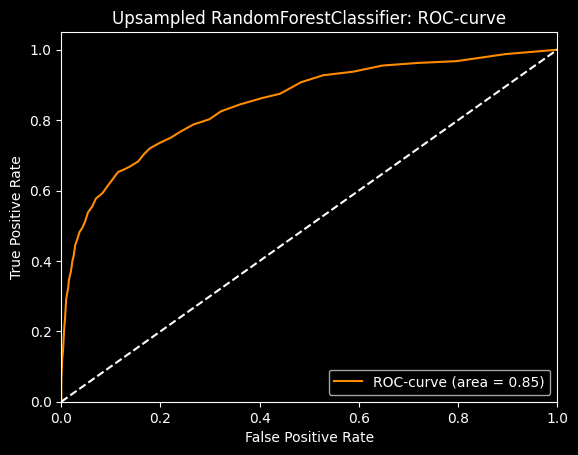

In [26]:
probabilities_valid = best_us_rf_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
us_rf_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'Upsampled RandomForestClassifier: ROC-AUC = {round(us_rf_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
us_rf_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(us_rf_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Upsampled RandomForestClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

#### Проверим как изменился результат на валидационной выборке после апсемплинга с моделью DecisionTreeClassifier

In [27]:
best_us_dt_model = None
best_us_dt_f1_result = 0
best_depth = 0
for depth in range(1, 20):
	model = DecisionTreeClassifier(random_state=1337, max_depth=depth)
	model.fit(x_upsampled, y_upsampled)
	predict_valid = model.predict(x_valid)
	f1_result = f1_score(predict_valid, y_valid)
	if f1_result > best_us_dt_f1_result:
		best_us_dt_model = model
		best_us_dt_f1_result = f1_result
		best_depth = depth
        
print("F1 лучшей модели DecisionTreeClassifier после апсемплинга:", round(best_us_dt_f1_result, 4), "при параметре max_depth =", best_depth)

F1 лучшей модели DecisionTreeClassifier после апсемплинга: 0.5665 при параметре max_depth = 7


#### Рассчитаем ROC-AUC и построим график

Upsampled DecisionTreeClassifier: ROC-AUC = 0.82


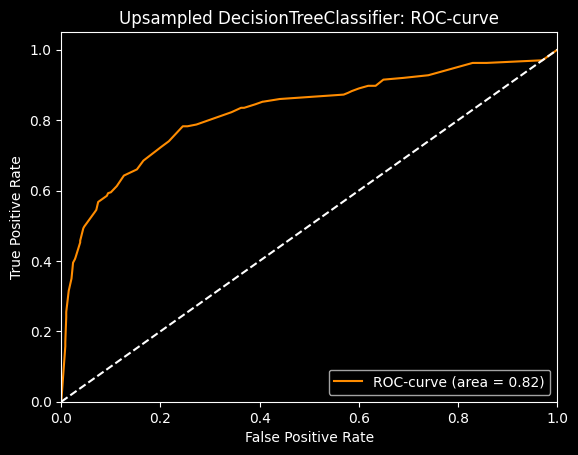

In [28]:
probabilities_valid = best_us_dt_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
us_dt_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'Upsampled DecisionTreeClassifier: ROC-AUC = {round(us_dt_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
us_dt_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(us_dt_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Upsampled DecisionTreeClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

#### Проверим как изменился результат на валидационной выборке после апсемплинга с моделью LogisticRegression

In [29]:
us_lr_model = LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000) 
us_lr_model.fit(x_upsampled, y_upsampled) 
predict_valid = lr_model.predict(x_valid)
us_lr_f1_result = f1_score(predict_valid, y_valid)

print("F1 модели LogisticRegression после апсемплинга:", round(us_lr_f1_result, 4))

F1 модели LogisticRegression после апсемплинга: 0.3258


#### Рассчитаем ROC-AUC и построим график

Upsampled LogisticRegression: ROC-AUC = 0.77


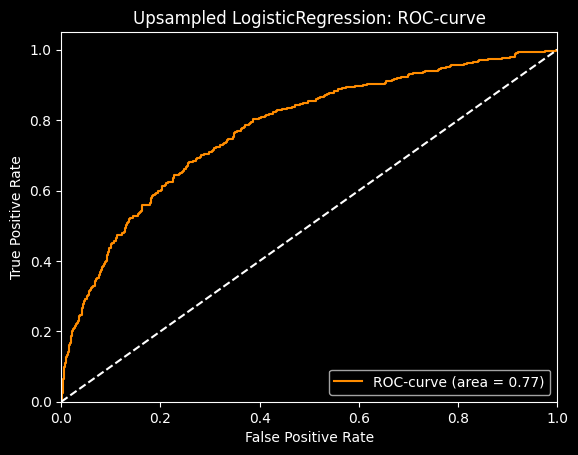

In [30]:
probabilities_valid = us_lr_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
us_lr_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'Upsampled LogisticRegression: ROC-AUC = {round(us_lr_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
us_lr_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(us_lr_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Upsampled LogisticRegression: ROC-curve')
plt.legend(loc="lower right")
plt.show()

### Downsampling

In [31]:
def downsample(x, y, fraction):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_downsampled = pd.concat(
        [x_zeros.sample(frac=fraction, random_state=1337)] + [x_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=1337)] + [y_ones])
    
    x_downsampled, y_downsampled = shuffle(
        x_downsampled, y_downsampled, random_state=1337)
    
    return x_downsampled, y_downsampled

x_downsampled, y_downsampled = downsample(x_train, y_train, 0.25)

In [32]:
print(f'в целевом признаке downsampled выборки вес класса "1" = {round(y_downsampled.sum() / len(y_downsampled), 2)}')

в целевом признаке downsampled выборки вес класса "1" = 0.51


#### Проверим как изменился результат на валидационной выборке после даунсемплинга с моделью RandomForestClassifier

In [33]:
best_ds_rf_model = None
best_ds_rf_f1_result = 0
best_est = 0
for est in range(10, 201, 10):
    model = RandomForestClassifier(random_state=1337, n_estimators=est)
    model.fit(x_downsampled, y_downsampled)
    predict_valid = model.predict(x_valid)
    f1_result = f1_score(predict_valid, y_valid)
    if f1_result > best_ds_rf_f1_result:
        best_ds_rf_model = model
        best_ds_rf_f1_result = f1_result
        best_est = est

print("F1 лучшей модели:", round(best_ds_rf_f1_result, 4), "при параметре n_estimators =", best_est)

F1 лучшей модели: 0.5772 при параметре n_estimators = 110


#### Рассчитаем ROC-AUC и построим график

Downsampled RandomForestClassifier: ROC-AUC = 0.85


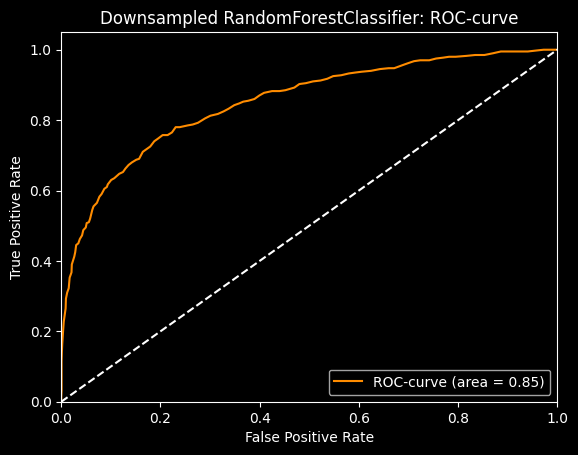

In [34]:
probabilities_valid = best_ds_rf_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
ds_rf_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'Downsampled RandomForestClassifier: ROC-AUC = {round(ds_rf_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
ds_rf_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(ds_rf_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Downsampled RandomForestClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

#### Проверим как изменился результат на валидационной выборке после даунсемплинга с моделью DecisionTreeClassifier

In [35]:
best_ds_dt_model = None
best_ds_dt_f1_result = 0
best_depth = 0
for depth in range(1, 20):
	model = DecisionTreeClassifier(random_state=1337, max_depth=depth)
	model.fit(x_downsampled, y_downsampled)
	predict_valid = model.predict(x_valid)
	f1_result = f1_score(predict_valid, y_valid)
	if f1_result > best_ds_dt_f1_result:
		best_ds_dt_model = model
		best_ds_dt_f1_result = f1_result
		best_depth = depth
        
print("F1 лучшей модели:", round(best_ds_dt_f1_result, 4), "при параметре max_depth =", best_depth)

F1 лучшей модели: 0.5551 при параметре max_depth = 6


#### Рассчитаем ROC-AUC и построим график

Downsample DecisionTreeClassifier: ROC-AUC = 0.83


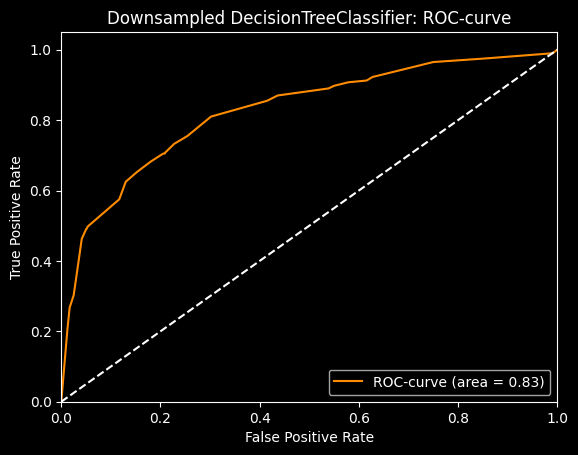

In [36]:
probabilities_valid = best_ds_dt_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
ds_dt_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'Downsample DecisionTreeClassifier: ROC-AUC = {round(ds_dt_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
ds_dt_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(ds_dt_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Downsampled DecisionTreeClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

#### Проверим как изменился результат на валидационной выборке после даунсемплинга с моделью LogisticRegression

In [37]:
ds_lr_model = LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000) 
ds_lr_model.fit(x_downsampled, y_downsampled) 
predict_valid = lr_model.predict(x_valid)
ds_lr_f1_result = f1_score(predict_valid, y_valid)

print("F1 модели:", round(ds_lr_f1_result, 4))

F1 модели: 0.3258


#### Рассчитаем ROC-AUC и построим график

Downsampled LogisticRegressionClassifier: ROC-AUC = 0.77


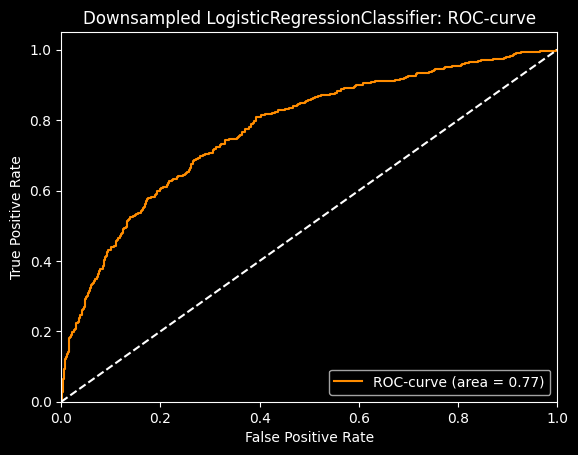

In [38]:
probabilities_valid = ds_lr_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
ds_lr_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'Downsampled LogisticRegressionClassifier: ROC-AUC = {round(ds_lr_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
ds_lr_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(ds_lr_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Downsampled LogisticRegressionClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

### Сравним модели

In [39]:
model_names = ['us_RandomForestClassifier',
               'us_DecisionTreeClassifier', 
               'us_LogisticRegressionClassifier', 
               'ds_RandomForestClassifier', 
               'ds_DecisionTreeClassifier', 
               'ds_LogisticRegressionClassifier'
               ]

f1_scores = [best_us_rf_f1_result,
             best_us_dt_f1_result, 
             us_lr_f1_result,
             best_ds_rf_f1_result,
             best_ds_dt_f1_result, 
             ds_lr_f1_result
             ]

roc_auc_scores = [us_rf_roc_auc,
                  us_dt_roc_auc, 
                  us_lr_roc_auc,
                  ds_rf_roc_auc,
                  ds_dt_roc_auc, 
                  ds_lr_roc_auc
                  ]

models_dif = pd.DataFrame({'Models':model_names,
                        'F1 Scores':f1_scores,
                        'ROC-AUS Scores':roc_auc_scores}
                       )
models_dif

,Models,F1 Scores,ROC-AUS Scores
0,us_RandomForestClassifier,0.62,0.85
1,us_DecisionTreeClassifier,0.57,0.82
2,us_LogisticRegressionClassifier,0.33,0.77
3,ds_RandomForestClassifier,0.58,0.85
4,ds_DecisionTreeClassifier,0.56,0.83
5,ds_LogisticRegressionClassifier,0.33,0.77


Вывод по методам борьбы с дисбалансом:

Апсемплинг показал себя лучше

### Попробуем усовершенствовать лучшую модель

In [40]:
best_us_fr_model = None
best_us_fr_f1_result = 0
best_est = 0
best_depth = 0
graf = {}
for est in range(200, 801, 100):
    for depth in range (1, 18):
        model = RandomForestClassifier(random_state=1337, n_estimators=est, max_depth=depth)
        model.fit(x_upsampled, y_upsampled)
        predict_valid = model.predict(x_valid)
        f1_result = f1_score(predict_valid, y_valid)
        graf[str(est)+"_"+str(depth)] = [est, depth, f1_result]
        if f1_result > best_us_fr_f1_result:
            best_us_fr_model = model
            best_us_fr_f1_result = f1_result
            best_est = est
            best_depth = depth

print("F1 лучшей модели:", round(best_us_fr_f1_result, 4), "при параметре n_estimators =", best_est, "и параметре best_depth =", best_depth)

F1 лучшей модели: 0.6399 при параметре n_estimators = 300 и параметре best_depth = 16


#### Построим график

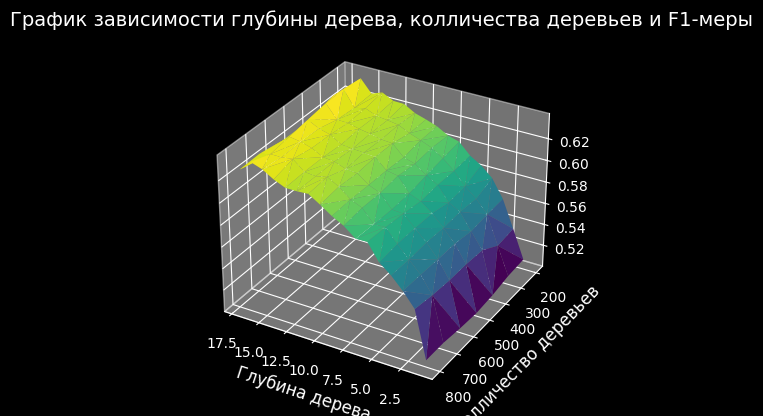

In [41]:
gr = pd.DataFrame.from_dict(graf).T
gr = gr.reset_index()
gr = gr.drop(['index'], axis = 1)
gr.columns = ["X","Y","Z"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(gr['Y'], gr['X'], gr['Z'], cmap = plt.cm.viridis, linewidth = 0.2)
ax.view_init(30, 120)
plt.title(f'График зависимости глубины дерева, колличества деревьев и F1-меры', 
              fontsize=14)
plt.xlabel('Глубина дерева', fontsize=12)
plt.ylabel('Колличество деревьев', fontsize=12)
plt.show()

In [42]:
best_us_rf_model = None
best_us_rf_f1_result = 0
best_est = 0
best_depth = 0
graf = {}
for est in range(250, 351, 10):
    for depth in range (15, 25):
        model = RandomForestClassifier(random_state=1337, n_estimators=est, max_depth=depth)
        model.fit(x_upsampled, y_upsampled)
        predict_valid = model.predict(x_valid)
        f1_result = f1_score(predict_valid, y_valid)
        graf[str(est)+"_"+str(depth)] = [est, depth, f1_result]
        if f1_result > best_us_rf_f1_result:
            best_us_rf_model = model
            best_us_rf_f1_result = f1_result
            best_est = est
            best_depth = depth

print("F1 лучшей модели:", round(best_us_rf_f1_result, 4), "при параметре n_estimators =", best_est, "и параметре best_depth =", best_depth)

F1 лучшей модели: 0.6425 при параметре n_estimators = 280 и параметре best_depth = 16


#### Построим график

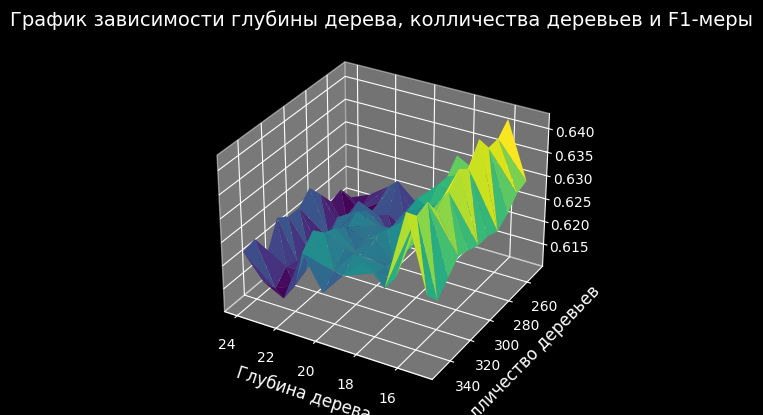

In [43]:
gr = pd.DataFrame.from_dict(graf).T
gr = gr.reset_index()
gr = gr.drop(['index'], axis = 1)
gr.columns = ["X","Y","Z"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(gr['Y'], gr['X'], gr['Z'], cmap = plt.cm.viridis, linewidth = 0.2)
ax.view_init(30, 120)
plt.title(f'График зависимости глубины дерева, колличества деревьев и F1-меры', 
              fontsize=14)
plt.xlabel('Глубина дерева', fontsize=12)
plt.ylabel('Колличество деревьев', fontsize=12)
plt.show()

In [44]:
def find_best_threshold(model, x_valid, y_valid, depth=2):
    probabilities_valid = model.predict_proba(x_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    start = 0.0
    end = 1.0
    step = 0.1
    best_threshold = 0.0
    best_f1 = 0.0
    
    while step >= 10 ** -depth:
        print(f'## start iteration with step {step}')
        for threshold in np.arange(start, end, step):
            predicted_valid = probabilities_one_valid > threshold
            precision = precision_score(y_valid, predicted_valid)
            recall = recall_score(y_valid, predicted_valid)
            f1 = f1_score(y_valid, predicted_valid)
            print(f'Threshold = {round(threshold, depth)} | Precision = {round(precision, 3)}, Recall = {round(recall, 3)}, F1 = {round(f1, 5)}')

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        start = best_threshold - step*0.9
        end = best_threshold + step
        step /= 10
        print(f'best f1 score on iteration = {round(best_f1, 4)} with trashold = {round(best_threshold, depth)}')
        print()

    return round(best_threshold, depth), round(best_f1, 4)

best_us_rf_threshold, best_us_rf_f1 = find_best_threshold(best_us_rf_model, x_valid, y_valid, depth=2)
print(f'Best Threshold = {best_us_rf_threshold}, Best F1 = {best_us_rf_f1}')

## start iteration with step 0.1
Threshold = 0.0 | Precision = 0.201, Recall = 1.0, F1 = 0.33459
Threshold = 0.1 | Precision = 0.284, Recall = 0.952, F1 = 0.43718
Threshold = 0.2 | Precision = 0.368, Recall = 0.852, F1 = 0.51394
Threshold = 0.3 | Precision = 0.461, Recall = 0.748, F1 = 0.57007
Threshold = 0.4 | Precision = 0.547, Recall = 0.688, F1 = 0.60908
Threshold = 0.5 | Precision = 0.667, Recall = 0.62, F1 = 0.64249
Threshold = 0.6 | Precision = 0.746, Recall = 0.507, F1 = 0.60417
Threshold = 0.7 | Precision = 0.828, Recall = 0.41, F1 = 0.54849
Threshold = 0.8 | Precision = 0.875, Recall = 0.262, F1 = 0.40385
Threshold = 0.9 | Precision = 0.955, Recall = 0.105, F1 = 0.18919
best f1 score on iteration = 0.6425 with trashold = 0.5

## start iteration with step 0.01
Threshold = 0.41 | Precision = 0.559, Recall = 0.682, F1 = 0.61486
Threshold = 0.42 | Precision = 0.57, Recall = 0.675, F1 = 0.61785
Threshold = 0.43 | Precision = 0.586, Recall = 0.662, F1 = 0.62207
Threshold = 0.44 | P

#### Рассчитаем ROC-AUC и построим график

RandomForestClassifier: ROC-AUC = 0.85


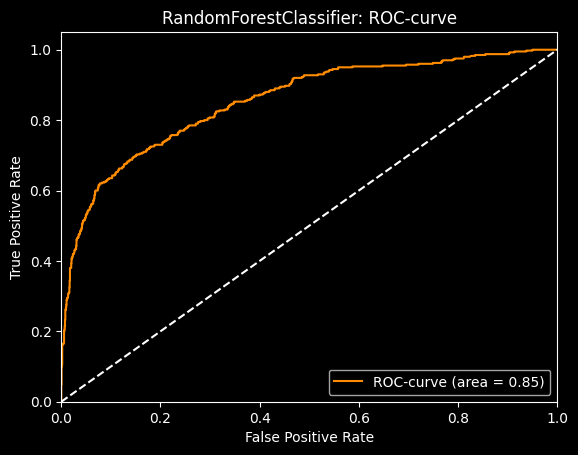

In [45]:
probabilities_valid = best_us_rf_model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
us_roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'RandomForestClassifier: ROC-AUC = {round(us_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_valid, probabilities_one_valid)
us_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(us_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForestClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

## Тестирование модели

In [46]:
probabilities_valid = best_us_rf_model.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > best_us_rf_threshold
test_f1 = f1_score(y_test, predicted_valid)

print(f'F1 лучшей модели на тестовой выборке: {test_f1}')

F1 лучшей модели на тестовой выборке: 0.6188579017264276


#### Рассчитаем ROC-AUC и построим график

RandomForestClassifier: ROC-AUC = 0.86


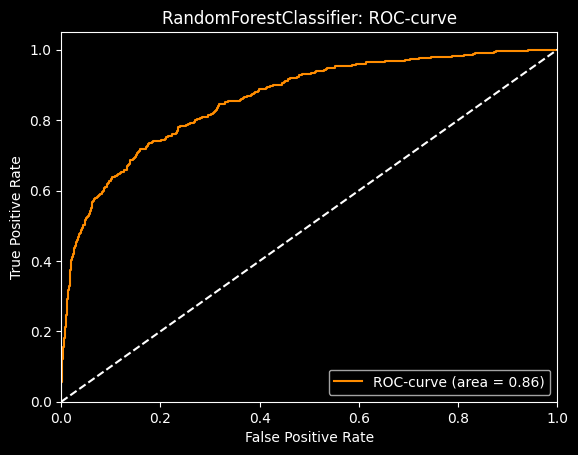

In [47]:
probabilities_valid = best_us_rf_model.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]
test_roc_auc = roc_auc_score(y_test, probabilities_one_valid)
print(f'RandomForestClassifier: ROC-AUC = {round(test_roc_auc, 2)}')

fpr, tpr, treshold = roc_curve(y_test, probabilities_one_valid)
test_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC-curve (area = {round(test_auc_score, 2)})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForestClassifier: ROC-curve')
plt.legend(loc="lower right")
plt.show()

### Проверим модель на адекватность

In [48]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=1337)
dummy_clf.fit(x_train, y_train)
dummy_predict = dummy_clf.predict(x_test)
dummy_f1 = f1_score(dummy_predict, y_test)

if test_f1 > dummy_f1:
    print(f'F1 метрика нашей модели ({round(test_f1, 4)}) '
    f'выше чем в модели случайного подбора параметров '
    f'({round(dummy_f1, 4)}), наша модель адекватна')
else:
    print(f'F1 метрика нашей модели ({round(test_f1, 4)}) '
    f'ниже чем чем в модели случайного подбора параметров '
    f'({round(dummy_f1, 4)}), наша модель неадекватна')

F1 метрика нашей модели (0.6189) выше чем в модели случайного подбора параметров (0.2968), наша модель адекватна


## Вывод

Данные разбиты на три выборки (тренировочная, валидационная, тестовая).
На тренировочных данных обучено три модели, лучшей оказалась модель `RandomForestClassifier`, показав метрику F1 = 0.63 на валидационной выборке. В данных исправлен дисбаланс методами апсемплинга и даунсемплинга, лучше оказался метод апсемплинга. Подобраны более качественные параметры методом перебора в цикле и найден лучший порог - качество модели улучшилось. Итоговый результат модели на тестовой выборке:
- F1 = 0.6189
- ROC-AUC = 0.86

Данные на тестовой выборке немного хуже чем на валидационной, модель немного переучена, но не критично, ожидаемый результат качества (F1 не менее чем 0.59) достигнут.
Модель так же прошла проверку на адекватность в сравнении со случайной Dummy моделью.